In [417]:
import sys
sys.path.append('../..')

from bitarray import bitarray
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import navbench as nb
from navbench import improc as ip
from navbench import navigation as nv
import numpy as np
from scipy.spatial import distance
import utm
import shutil
from math import sqrt
from joblib import Parallel, delayed
import pickle
import cv2
import csv



dbroot = '../../../../../media/sdd1/dataset/'

skipframe = 100

In [331]:
# get directories
directories =  os.listdir(dbroot)
directories =  sorted(directories)
dataframes = []
for i in range(1, len(directories)):
    print(directories[i])
    df = pd.read_csv(dbroot + directories[i]+ "/database_entries.csv") 
    dataframes.append(df)


imgdataset_02-03-2021_16-26-23
imgdataset_03-03-2021_15-3-14
imgdataset_03-03-2021_15-37-49
imgdataset_08-03-2021_12-21-25
imgdataset_08-03-2021_12-48-36
imgdataset_14-04-2021_15-11-16
imgdataset_20-04-2021_13-57-21
imgdataset_20-04-2021_14-19-40
imgdataset_22-03-2021_15-55-44
imgdataset_22-03-2021_17-7-43
imgdataset_22-04-2021_13-48-15
imgdataset_26-04-2021_16-21-52
imgdataset_26-04-2021_16-42-19


In [431]:
# adding the unwrapped suffix to each database entries at Filename so that the database reader reads in correct order 
# this function is only needed if the csv file copied over from wrapped images and Filename does not contain unwrapped suffix
# this will check for the suffix and update the csv files 
directories =  os.listdir(dbroot)
directories =  sorted(directories)
dataframes = []
for i in range(1, len(directories)):
    print(directories[i])
    csv_path = dbroot + directories[i]+ "/unwrapped_images/database_entries.csv"
    df = pd.read_csv(csv_path,quoting=csv.QUOTE_NONE, error_bad_lines=False) 
    # if the csv file does not have the unwrapped suffix, add it
    bool_series = df['Filename'].str.startswith('image') 
    bool_series_nan = pd.isna(df['Filename'])
    if sum(bool_series) > 0 :
        print('filename does not contain suffix: unwrapped - updating csv')
        df['Filename'] = 'unwrapped_' + df['Filename'].astype(str)
        df.to_csv(csv_path)
    # we are checking for NaN filenames (in case the reorder terminated unexpectedly - solution remove last line : double check first)
    if sum(bool_series_nan) > 0 :
        print('filename [' + csv_path + '] contains NaN')
    dataframes.append(df)



imgdataset_02-03-2021_16-26-23
imgdataset_03-03-2021_15-3-14
imgdataset_03-03-2021_15-37-49
imgdataset_08-03-2021_12-21-25
imgdataset_08-03-2021_12-48-36
imgdataset_14-04-2021_15-11-16
imgdataset_20-04-2021_13-57-21
imgdataset_20-04-2021_14-19-40
imgdataset_22-03-2021_15-55-44
imgdataset_22-03-2021_17-7-43
imgdataset_22-04-2021_13-48-15
imgdataset_26-04-2021_16-21-52
imgdataset_26-04-2021_16-42-19


In [332]:

coordinates = []
for i in range(0, len(dataframes)) :
    dataset_coord = []
    dfx = dataframes[i]["X [mm]"]
    dfy = dataframes[i]["Y [mm]"]
    dataset_coord.append(dfx)
    dataset_coord.append(dfy)
    coordinates.append(dataset_coord)


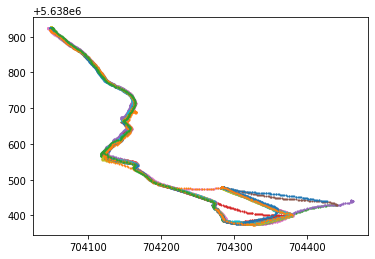

In [432]:
skipframe_coord = 10
markersize = 1
marker = 'o'

_, ax = plt.subplots()
for i in coordinates : 
    ax.scatter(i[0][::skipframe_coord],i[1][::skipframe_coord],marker=marker, s=markersize)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa17c1fee48>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa181b02390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa18ce8c518>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa1416c5c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa19a3d9c88>],
 'means': []}

Text(0.5, 1.0, 'starting coordinates and distances')

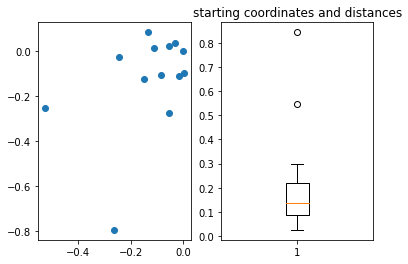

In [433]:
# drawing starting coordinates
#for i in coordinates : 


start_x = []
start_y = []

for i in range(0, len(coordinates)):
   
    xpos=coordinates[i][0][0]
    ypos=coordinates[i][1][0]
    start_x.append(xpos)
    start_y.append(ypos)

_, ax = plt.subplots(ncols=2)
start_x-=start_x[-1]
start_y-=start_y[-1]
start_x/=10
start_y/=10
ax[0].scatter(start_x,start_y)
sx0 = start_x[0]
sy0 = start_y[0]
distances = []
for i in range(1, len(start_x)) :
    sxi = start_x[i]
    syi = start_y[i]
    dist = sqrt( (sx0 - sxi)*(sx0 - sxi) + (sy0 - syi)*(sy0 - syi) )
    distances.append(dist)

ax[1].boxplot(distances)
plt.title("starting coordinates and distances")
plt.show()



In [434]:

# comparing routes with dct 
def get_rotations(im, total_rotations = 60) :
    length = len(im[0])
    skiprot = int(length/total_rotations)

    rotated_ims = []
    for rot in range(0, length, skiprot) :
        rotated = np.roll(im, -rot, axis=1)
        rotated_ims.append(rotated)
    return rotated_ims

def angle_diff(a, b) :
    return 180 - math.fabs(math.fmod(math.fabs(a - b), 2*180) - 180)

def get_rothashes(im) :
    im_rots = get_rotations(im)
    rotated_hashes = []
    for r in im_rots : 
        rotated_hashes.append(ip.dct_hash(r))
    return rotated_hashes
    

def create_training_matrix(reference_imgs, skip) :
    print("creating matrix")
    hash_ref_matrix = []
    for im in range(0, len(reference_imgs),skip)  :
        rotated_hashes = get_rothashes(reference_imgs[im])
        hash_ref_matrix.append(rotated_hashes)
    return hash_ref_matrix


def getBest(hash_matrix, query_hash) :

    results = ip.hash_distance_vector(hash_matrix, query_hash)
    return results

def read_database(path, width=60, height=20) :
    db1 = nb.Database(path)
    ims = db1.read_images(preprocess=[ip.histeq,ip.resize(width,height)])
    return db1, ims
            

    

In [84]:
# deserialise saved data - commented out so I don't accidentally destroy new data
#pickle_off = open("training_matrices_bitset","rb")
#training_matrices = pickle.load(pickle_off)

# deserialise images 
#picle_off_imgs = open("database_images", "rb")
#database_images = pickle.load(picle_off_imgs)

In [389]:
# parallel reading of directories 
db_dir_names = []
for i in range(1, len(directories)):
    current_directory = dbroot+directories[i]+'/unwrapped_images'
    db_dir_names.append(current_directory)
tic = time.perf_counter()
database_images = Parallel(n_jobs=-1, prefer="threads",verbose=10)(delayed(read_database)(i) for i in db_dir_names)
toc = time.perf_counter()
print("parallel reading took " + str(toc - tic) + "seconds")

 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
Loading database at ../../../../../media/sdd1/dataset/imgdataset_02-03-2021_16-26-23/unwrapped_images...
Loading database at ../../../../../media/sdd1/dataset/imgdataset_03-03-2021_15-37-49/unwrapped_images...Loading database at ../../../../../media/sdd1/dataset/imgdataset_08-03-2021_12-21-25/unwrapped_images...
Loading database at ../../../../../media/sdd1/dataset/imgdataset_14-04-2021_15-11-16/unwrapped_images...
Loading database at ../../../../../media/sdd1/dataset/imgdataset_20-04-2021_14-19-40/unwrapped_images...Loading database at ../../../../../media/sdd1/dataset/imgdataset_22-03-2021_15-55-44/unwrapped_images...Loading database at ../../../../../media/sdd1/dataset/imgdataset_22-03-2021_17-7-43/unwrapped_images...Loading database at ../../../../../media/sdd1/dataset/imgdataset_22-04-2021_13-48-15/unwrapped_images...
Loading database at ../../../../../media/sdd1/dataset/imgdataset_26-04-2021_16-42-1

AttributeError: 'float' object has no attribute 'strip'

In [288]:

# parallel processing training data 

tic = time.perf_counter()
training_matrices = Parallel(n_jobs=-1, prefer="threads",verbose=10)(delayed(create_training_matrix)(i[1],skip=skipframe) for i in database_images)
toc = time.perf_counter()
print("parallel training matrix creation took " + str(toc - tic) + "seconds")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
creating matrix
[Parallel(n_jobs=-1)]: Done   2 out of  13 | elapsed:   21.1s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:   41.0s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   6 out of  13 | elapsed:   43.7s remaining:   50.9s
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:   43.9s remaining:   27.5s
parallel training matrix creation took 44.42256209102925seconds
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:   44.3s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   44.4s finished


In [8]:
#

In [87]:
# serialise images  
filename = 'database_images'
outfile = open(filename,'wb')
pickle.dump(database_images,outfile)
outfile.close()

In [90]:
# serialise data 
filename = 'training_matrices_bitset'
outfile = open(filename,'wb')
pickle.dump(training_matrices,outfile)
outfile.close()
    


query = 3300
3300


[[28 28 32 ... 34 30 28]
 [28 30 32 ... 30 28 30]
 [28 30 28 ... 24 26 30]
 ...
 [26 26 28 ... 30 30 28]
 [36 34 32 ... 34 36 38]
 [36 32 32 ... 32 34 34]]


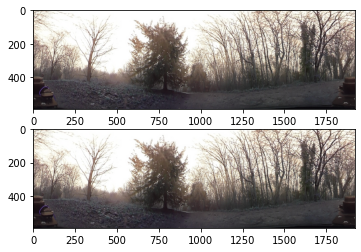

In [326]:
query_num = 2
ref_num = 2
query = int(3333/skipframe) # image number to compare #
print("query = " + str(query*skipframe))

query_hash = training_matrices[query_num][query][0] # query hash 
im1 = database_images[query_num][1][query] # query image
_, ax = plt.subplots(2)
reference = training_matrices[ref_num]
dists, ind = ip.hash_distance_vector(reference, query_hash )
print(ind[0]*skipframe)
ref_directory = dbroot+directories[ref_num]+'/unwrapped_images/'
query_directory = dbroot+directories[query_num]+'/unwrapped_images/'
ref_img_path = ref_directory + 'unwrapped_image' + str(ind[0]*skipframe) + '.jpg'
query_img_path = query_directory + 'unwrapped_image' + str(query*skipframe) + '.jpg'

# showing the high resolution version of the match
refim = cv2.imread(ref_img_path)
querim = cv2.imread(query_img_path)
ax[0].imshow(querim,cmap='gray')
ax[1].imshow(refim,cmap='gray')


# showing the actual match
#ref_im = database_images[ref_num][1][ind[0]]
#ax[0].imshow(im1,cmap='gray')
#ax[1].imshow(ref_im,cmap='gray')


[[26 30 26 ... 26 26 26]
 [26 28 26 ... 26 26 26]
 [28 28 26 ... 26 26 26]
 ...
 [24 30 30 ... 26 24 24]
 [24 28 32 ... 26 22 22]
 [24 30 32 ... 26 22 22]]
(5000, 0)
[[28 30 28 ... 36 32 32]
 [28 28 28 ... 36 32 32]
 [28 30 28 ... 36 32 34]
 ...
 [34 32 32 ... 32 32 32]
 [32 32 32 ... 34 34 34]
 [32 32 32 ... 34 32 34]]
(4331, 4)
[[30 26 24 ... 26 28 26]
 [30 26 24 ... 26 28 28]
 [30 28 24 ... 26 28 28]
 ...
 [32 30 32 ... 32 34 30]
 [32 34 32 ... 34 34 34]
 [30 34 30 ... 34 32 32]]
(2776, 58)
[[34 30 30 ... 32 30 32]
 [34 30 30 ... 32 30 30]
 [34 30 30 ... 32 30 30]
 ...
 [30 30 32 ... 26 28 28]
 [34 34 32 ... 32 32 32]
 [32 32 34 ... 32 34 34]]
(199, 20)
[[30 30 30 ... 34 28 30]
 [30 32 30 ... 32 28 30]
 [30 32 32 ... 32 28 30]
 ...
 [32 32 30 ... 22 22 24]
 [32 32 30 ... 24 22 26]
 [32 32 32 ... 24 22 26]]
(4548, 0)
[[28 30 28 ... 38 34 32]
 [28 30 28 ... 38 32 32]
 [28 30 26 ... 38 32 32]
 ...
 [34 36 36 ... 32 30 30]
 [36 36 36 ... 32 32 30]
 [34 36 38 ... 32 32 30]]
(7648, 2)
[[2

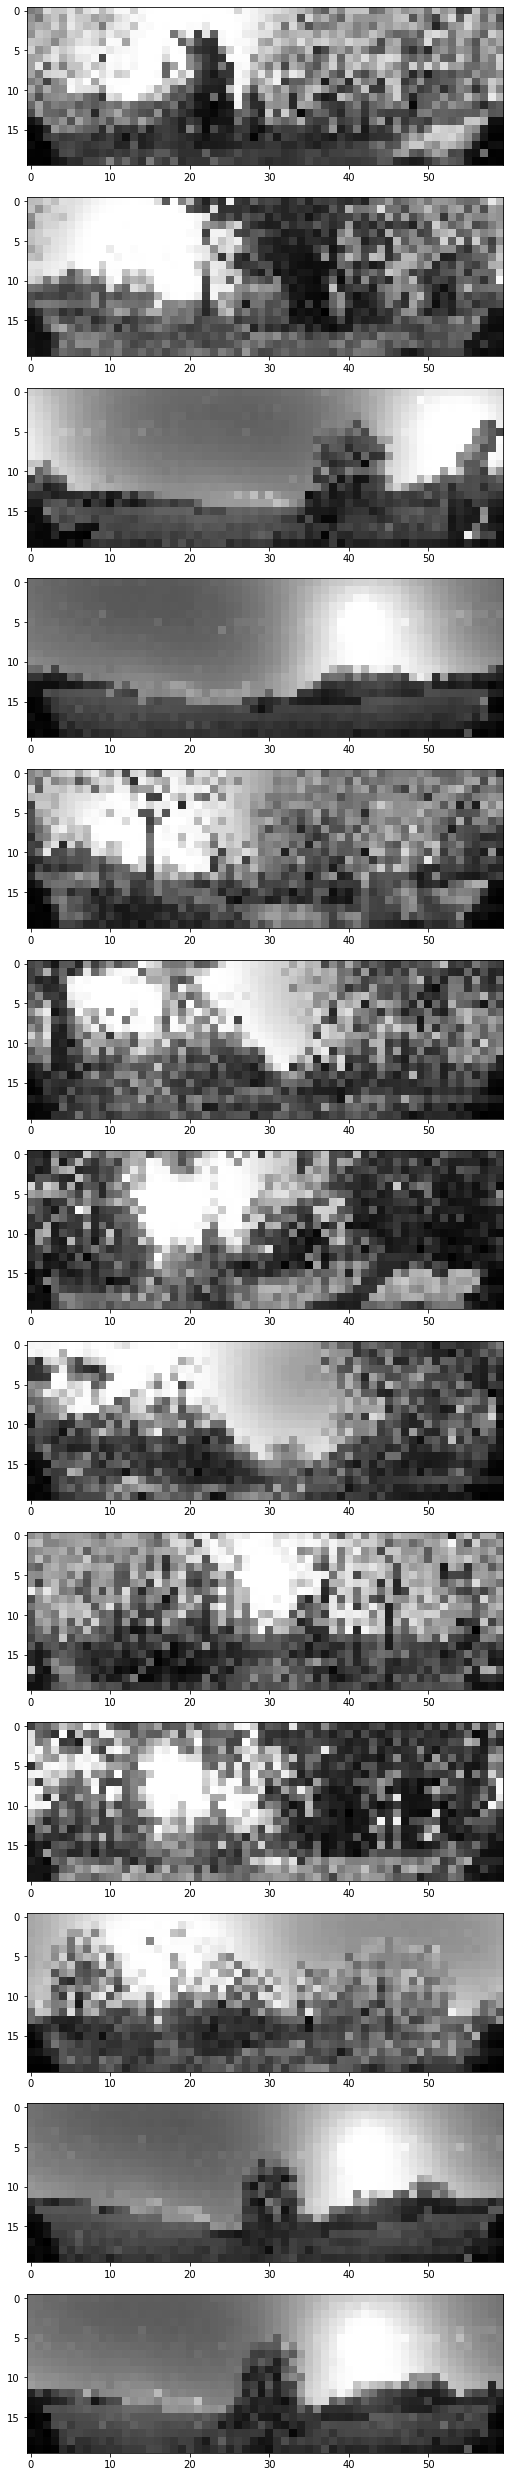

In [240]:
# example matching 
query_num = 0
query = 5000 # image number to compare #

query_hash = training_matrices[query_num][query][0] # query hash 
im1 = database_images[query_num][1][query] # query image
_, ax = plt.subplots(len(database_images),figsize=(15, 45))

for i in range(0,len(database_images)):

    reference = training_matrices[i]
    dists, ind = ip.hash_distance_vector(reference, query_hash )
    dists = np.asarray(dists)
    print((dists))
    print(ind)
    ref_im = database_images[ref_num][1][ind[0]]
    ax[i].imshow(ref_im,cmap='gray')

    






In [7]:

simulation_results = Parallel(n_jobs=-1, prefer="threads",verbose=10)(delayed(ip.hash_distance_vector)(training_matrices[0], i[0]) for i in training_matrices[1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.8min
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/norbert/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-47b3241cf42f>", line 1, i

TypeError: object of type 'NoneType' has no len()